### SETUP PACKAGES AND READ IN IMAGES

In [2]:
#import needed libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
import glob


C:\Users\eebla\AppData\Local\Temp\ipykernel_12708\779832599.py:9: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
#getting rid of images that are not the correct extension or are corrupt.
# also manually got rid of small images <10KB
data_dir = (r'C:\Users\eebla\OneDrive\Documents\side_project')
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)): #it is looping through each of the folders and then all the images in each
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))


### LOAD IN IMAGES WITH TENSORFLOW

In [5]:
#I dont have an NVIDIA graphis card:(
# fun fact if a filename is in chinese it breaks it
#defualt size is 256,256 and 32 per batch, shuffle is true going to need to get them to 224x224 for transfer learning model
#tf.keras.utils.image_dataset_from_directory??

#set wanted image size
IMAGE_SIZE=[224,224]
#set up the directory, tf likes to have subfolders with labels
data_dir = (r'C:\Users\eebla\OneDrive\Documents\side_project')
data= tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(IMAGE_SIZE))


Found 552 files belonging to 2 classes.


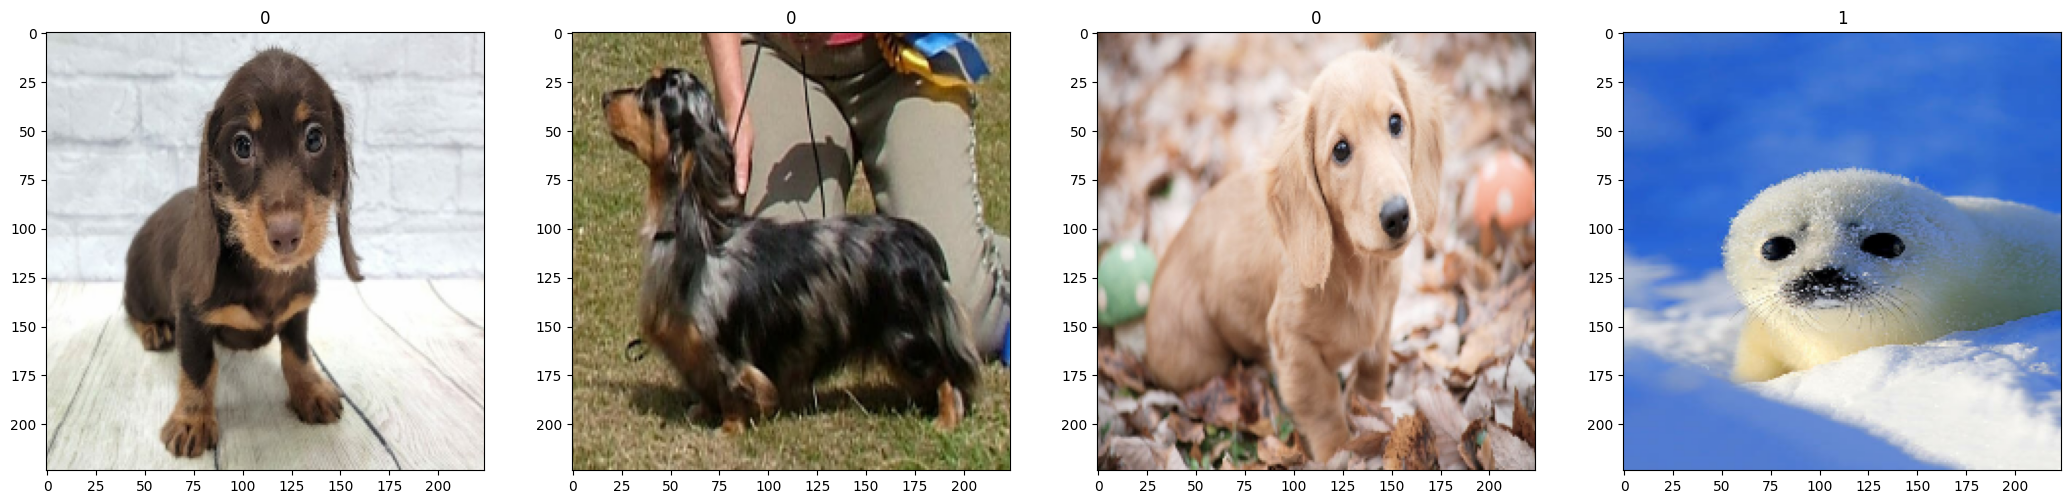

In [6]:
#iterate through images and look at some of them 
#dachshunds are labeled as 1 and chihuahuas are labled as 0
# can run this a bunch and see different batches of 32
data_iterator = data.as_numpy_iterator() #images represented by numpy arrays, grabs batches of 32
batch = data_iterator.next()
batch[0] #this is the arrays reprensting the image
batch[1] #this array represents the labels aka dachshund or seal

fig, ax = plt.subplots(ncols=4, figsize=(26,26))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### PREPROCESS
#### Need to scale data and then split into train, validation and test

Min: 0.0
Max: 1.0


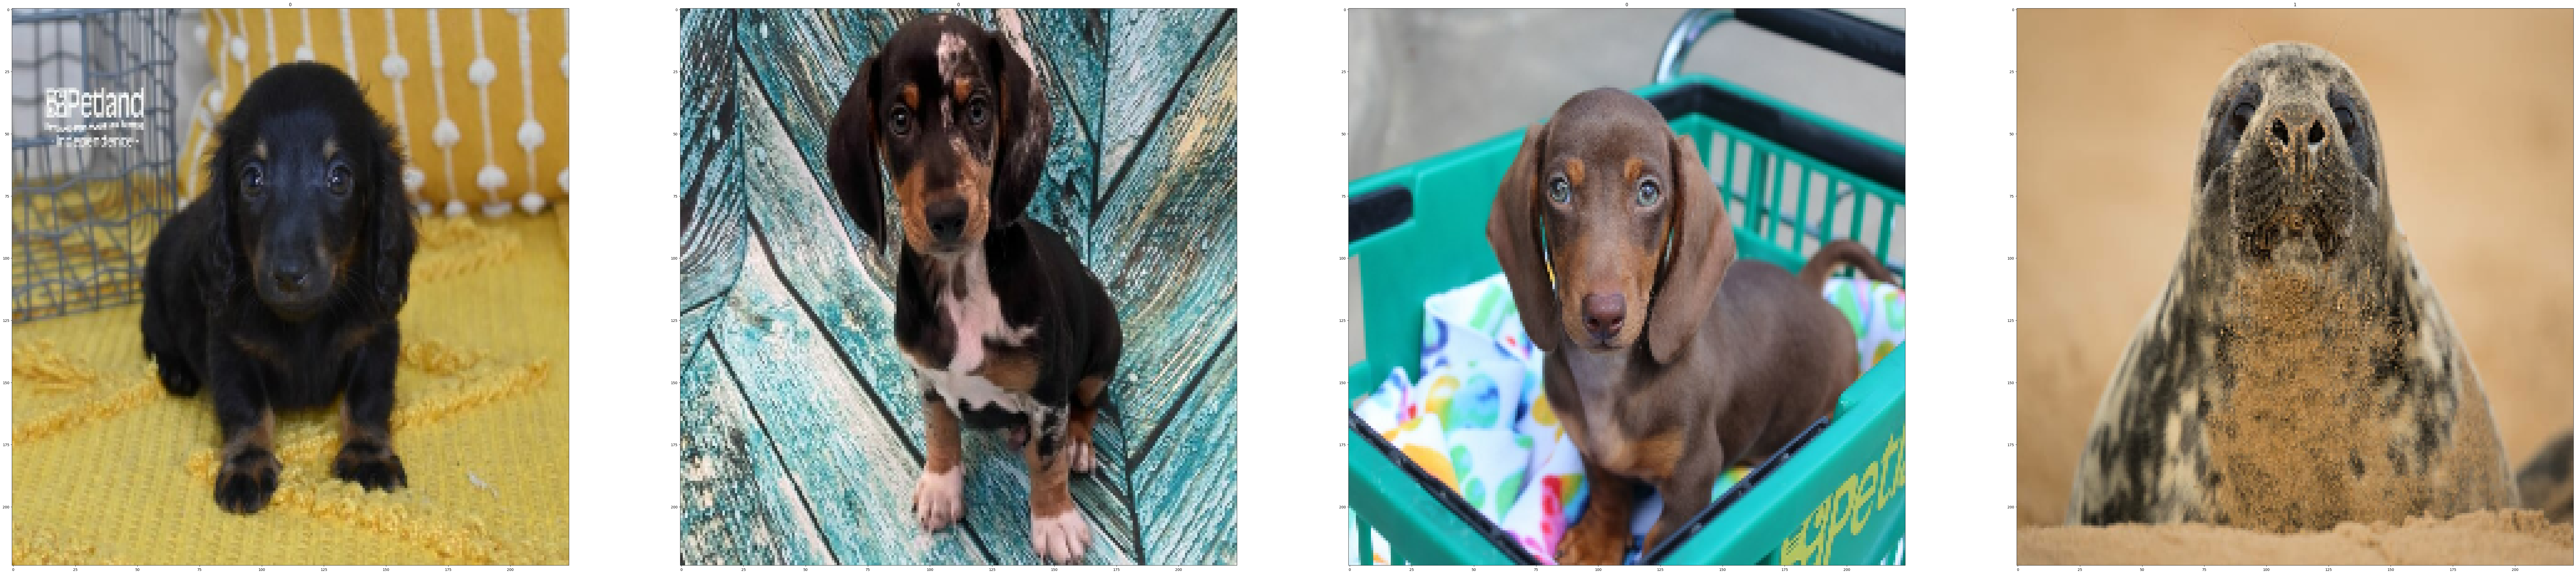

In [8]:
# SCALE- need to scale the arrays from 0 to 1 instead of 0 to 255 (the color scale goes to 255), its in RGB with tensorflow, its BGR with open_cv.
#tensorflow data api -> can see what other functions you can do in the pipeline

#Need to apply this to the pipeline instead of doing it after batch comes in
#x is the images and y is the labels
data=data.map(lambda x,y:(x/255,y)) #the map function is from tf
batch=data.as_numpy_iterator().next()

#checking, looks good this will work. 
print(f'Min: {batch[0].min()}')
print(f'Max: {batch[0].max()}')

#they are all black
fig, ax = plt.subplots(ncols=4, figsize=(128,128))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) #take out as type is int because they would all be 0 since we scaled it
    ax[idx].title.set_text(batch[1][idx])


### SPLIT INTO TRAIN, VALIDATE AND TEST

In [10]:
print(len(data)) #there are 18 batches of 32

train_size = 13
val_size = 3
test_size = 2

print(train_size)
print(val_size)
print(test_size)

#the take is telling how many batches to do, data is shuffled so there are a mix of 0s and 1s in each batch
train = data.take(train_size) 
val = data.skip(train_size).take(val_size)  
test = data.skip(train_size+val_size).take(test_size) 


18
13
3
2


 ### CNN with augmentation and transfer learning

In [12]:
import tf_keras as tfk
input_shape = (None,224, 224, 3)
hub_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-feature-vector/2"

model = tfk.Sequential([
    tfk.layers.RandomFlip(mode='horizontal'),  #randomly flips horizontal
    tfk.layers.RandomFlip(mode='vertical'),  #randomly flips vertical
    tfk.layers.RandomRotation(0.1), #randomly rotates
    tfk.layers.RandomZoom(0.1),
    tfk.layers.RandomZoom(0.3),
    hub.KerasLayer(hub_url, trainable=False),  # Can be True, see below.
    tfk.layers.Flatten(),
    tfk.layers.Dense(1, activation='sigmoid') # output layer
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              410208    
                                                        

In [13]:
#fitting model on training- validation went down around 10 then went back up
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10



13/13 [==============================] - 10s 398ms/step - loss: 0.4871 - accuracy: 0.7620 - val_loss: 0.4013 - val_accuracy: 0.7500
Epoch 2/10
13/13 [==============================] - 4s 329ms/step - loss: 0.2575 - accuracy: 0.8870 - val_loss: 0.1865 - val_accuracy: 0.9583
Epoch 3/10
13/13 [==============================] - 5s 347ms/step - loss: 0.1979 - accuracy: 0.9303 - val_loss: 0.1208 - val_accuracy: 0.9688
Epoch 4/10
13/13 [==============================] - 4s 306ms/step - loss: 0.1364 - accuracy: 0.9615 - val_loss: 0.0792 - val_accuracy: 0.9896
Epoch 5/10
13/13 [==============================] - 5s 358ms/step - loss: 0.1214 - accuracy: 0.9736 - val_loss: 0.1021 - val_accuracy: 0.9688
Epoch 6/10
13/13 [==============================] - 4s 302ms/step - loss: 0.1035 - accuracy: 0.9736 - val_loss: 0.0723 - val_accuracy: 0.9896
Epoch 7/10
13/13 [==============================] - 5s 338ms/step - loss: 0.0830 - accuracy: 0.9880 - val_loss: 0.0642 - val_accuracy: 0.9792
Epoch 8/10
13/13

### PLOT THE PERFORMANCE

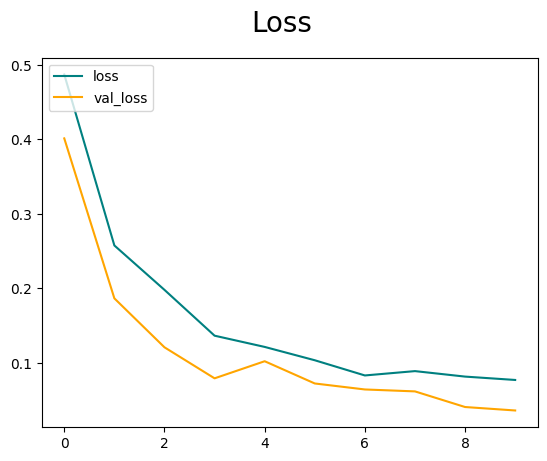

In [15]:
#hist.history can see the accuracy, loss is stored for training and validation
#looks great, both the training and validation loss is decreasing over time
#plot loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss') #traiing loss
plt.plot(hist.history['val_loss'], color='orange', label='val_loss') #validation loss
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

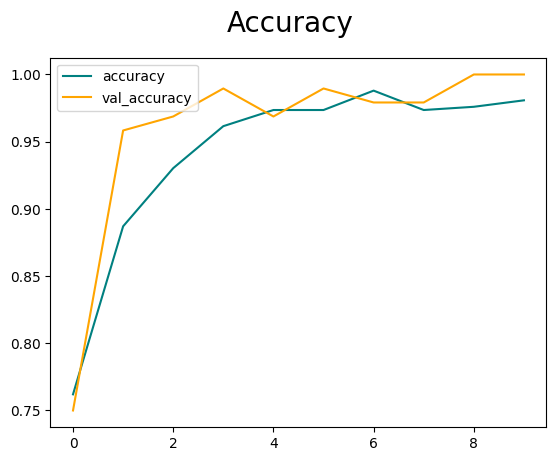

In [16]:
#plot accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy') #training accuracy
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy') #validation accuracy
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### EVALUATION ON TEST SET
## 97.5% accuracy!

In [18]:
#97% accuracy
loss, acc = model.evaluate(test)
print(f"Test Loss: {loss}, Test Accuracy: {acc}")


2/2 [==============================] - 1s 81ms/step - loss: 0.0702 - accuracy: 0.9750
Test Loss: 0.07015858590602875, Test Accuracy: 0.9750000238418579


### MORE testing
#### Testing pics of my own dachshunds and some seals. I added the picture of seal the singer just for fun and then a doxie that is dressed like a seal too. It did get these two pics that I threw in there to see what it did wrong, which is understandable. All the other 14 it got correct. 

1/1 [==============================] - 0s 112ms/step - loss: 0.2397 - accuracy: 0.8750
Evaluation results (loss and metrics): [0.23973479866981506, 0.875]
Sample 0: Predicted Prob: [0.03113617], Predicted Class: Dachshund, Actual Class: Dachshund, Correct: Yes


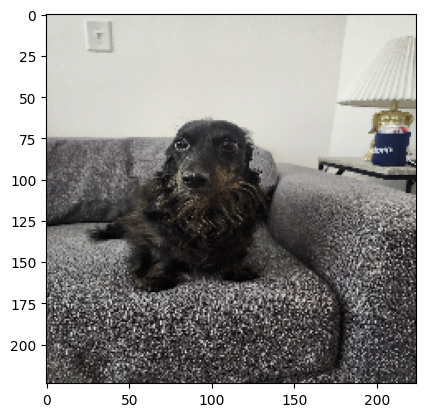

Sample 1: Predicted Prob: [0.07232502], Predicted Class: Dachshund, Actual Class: Dachshund, Correct: Yes


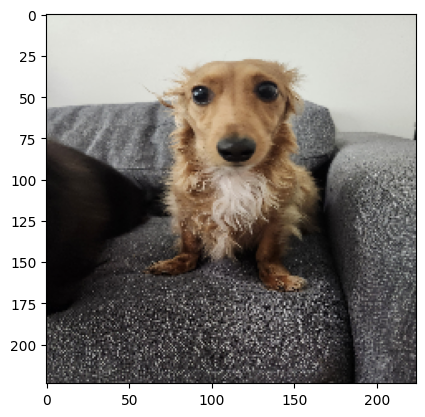

Sample 2: Predicted Prob: [0.00783752], Predicted Class: Dachshund, Actual Class: Dachshund, Correct: Yes


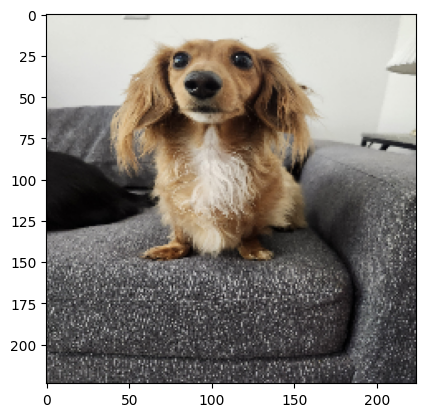

Sample 3: Predicted Prob: [0.01211305], Predicted Class: Dachshund, Actual Class: Dachshund, Correct: Yes


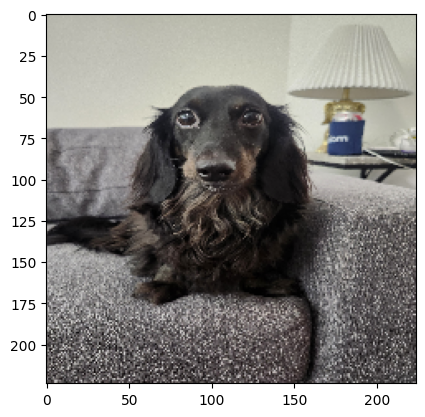

Sample 4: Predicted Prob: [0.01924935], Predicted Class: Dachshund, Actual Class: Dachshund, Correct: Yes


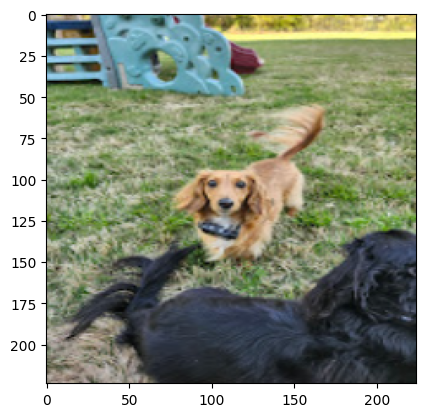

Sample 5: Predicted Prob: [0.04599791], Predicted Class: Dachshund, Actual Class: Dachshund, Correct: Yes


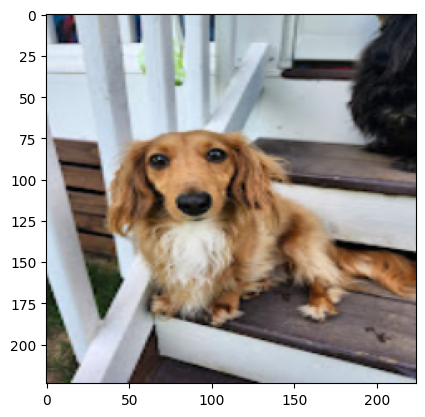

Sample 6: Predicted Prob: [0.15773259], Predicted Class: Dachshund, Actual Class: Dachshund, Correct: Yes


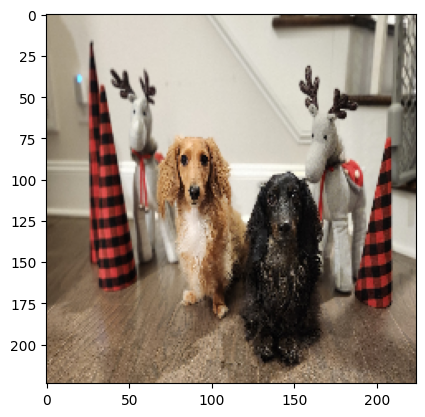

Sample 7: Predicted Prob: [0.00671128], Predicted Class: Dachshund, Actual Class: Dachshund, Correct: Yes


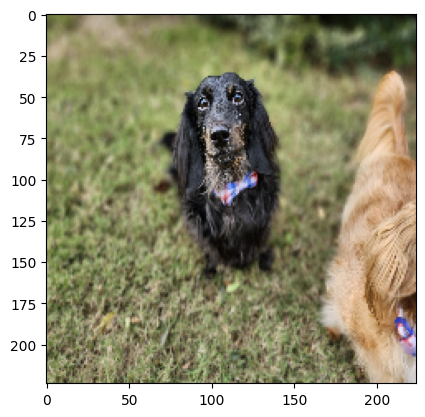

Sample 8: Predicted Prob: [0.5449361], Predicted Class: Seal, Actual Class: Dachshund, Correct: No


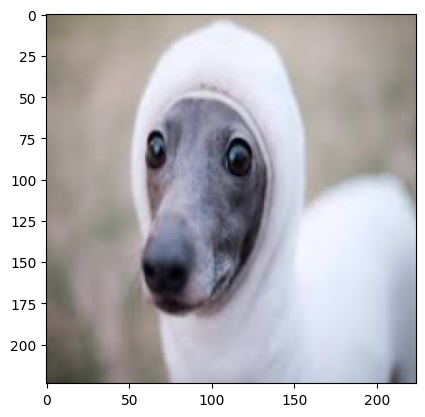

Sample 9: Predicted Prob: [0.9699567], Predicted Class: Seal, Actual Class: Seal, Correct: Yes


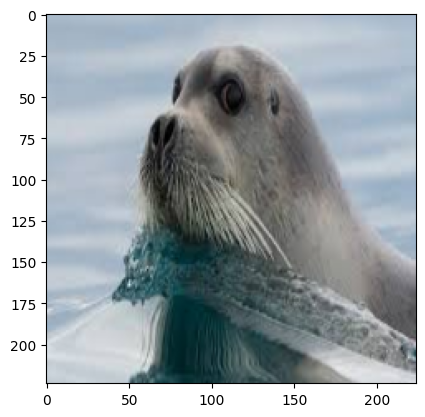

Sample 10: Predicted Prob: [0.97352517], Predicted Class: Seal, Actual Class: Seal, Correct: Yes


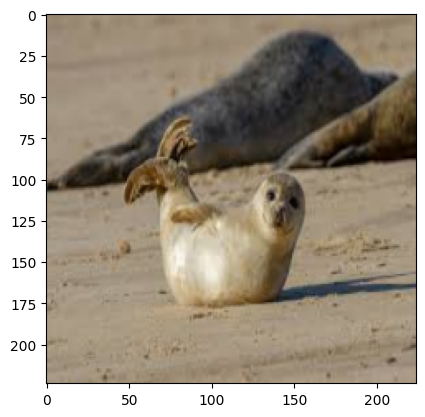

Sample 11: Predicted Prob: [0.45076117], Predicted Class: Dachshund, Actual Class: Dachshund, Correct: Yes


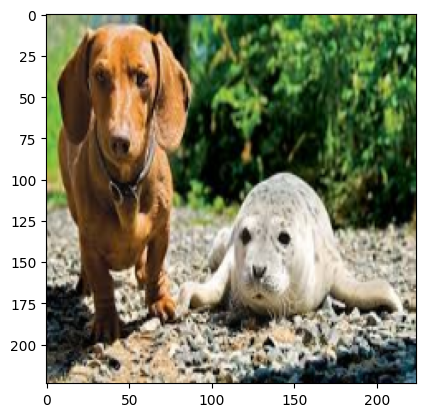

Sample 12: Predicted Prob: [0.2904372], Predicted Class: Dachshund, Actual Class: Seal, Correct: No


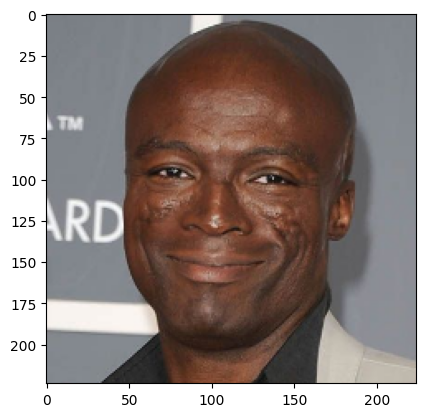

Sample 13: Predicted Prob: [0.9601685], Predicted Class: Seal, Actual Class: Seal, Correct: Yes


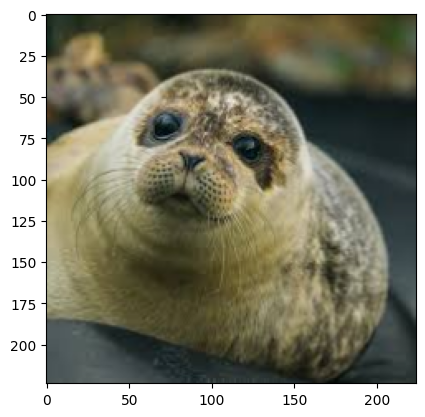

Sample 14: Predicted Prob: [0.5726414], Predicted Class: Seal, Actual Class: Seal, Correct: Yes


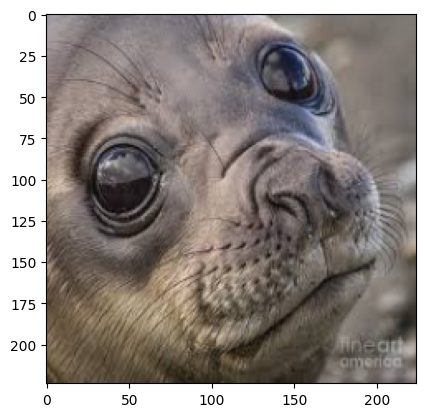

Sample 15: Predicted Prob: [0.83052844], Predicted Class: Seal, Actual Class: Seal, Correct: Yes


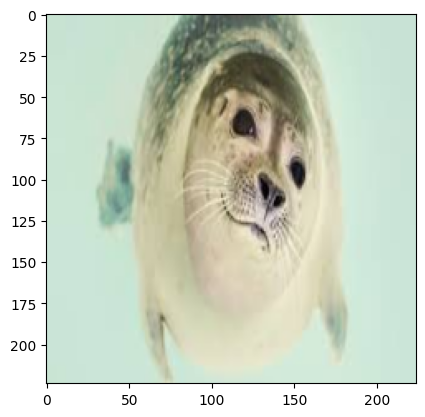

In [20]:
#test on my dachshunds Cannoli and Biscotti and my old boss's chihuahua peachy
#since we are using open cv its showing them in bgr that is why it looks a little off colorwise, fixed it

#this is my folder path that I have the testing photos in
folder_path = r'C:\Users\eebla\OneDrive\Documents\testing'

image_files = glob.glob(f"{folder_path}\\*.jpg") 
#create an empty list to load the images into 
images = []

#loop through the files in the folder and resize them
for file in image_files:
    img = cv2.imread(file)
    if img is not None:
        # Resize the image using cv2.resize
        img_resized = cv2.resize(img, IMAGE_SIZE)
        images.append(img_resized)
    else:
        print(f"Warning: Could not read image {file}")

#covert the list to a numpy array
test_x = np.array(images)

#scale the images
test_x_scaled = test_x / 255.0

#these are the true labels
test_out_y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1])

#pedict on the new test data
preds = model.predict(test_x_scaled)

eval=model.evaluate(test_x_scaled,test_out_y)
print("Evaluation results (loss and metrics):", eval)

threshold=0.5
#print out predictions and their actual class
# Loop through predictions and actual labels
#did great on the test pics that were not sneaky hehe, seal the person and the doxie dressed as a seal
for i, (pred, actual,img) in enumerate(zip(preds, test_out_y,images)):
    # Convert the predicted probability to a binary class label
    predicted_class = 'Seal' if pred >= threshold else 'Dachshund'
    actual_class='Seal' if actual==1 else 'Dachshund'
    correct='Yes' if predicted_class==actual_class else "No"
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(f"Sample {i}: Predicted Prob: {pred}, Predicted Class: {predicted_class}, Actual Class: {actual_class}, Correct: {correct}")
    plt.imshow(img_rgb)
    plt.show()
